In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# set the fail rate to test
a_fail_rate = 50

# name of the output folder:
name_of_project = 'bassin_report_aare'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")
land_use_map = PILImage.open("resources/maps/land_use_aare.jpeg")

# the search term for the river bassin
bassin_name = 'aare'

lakes_of_interest = ['thunersee', 'bielersee', 'neuenburgersee']
lake_colors=["darkblue", "royalblue", "cadetblue"]


# the names for the survey area and the cumulative data
level_names = ["Aare survey area","All survey areas"]

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 50
unit_label = 'p/50m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# colors for gradients
colors = ['beige', 'navajowhite', 'sandybrown', 'salmon', 'sienna']
nodes = [0.0, 0.2, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

# Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQAASL)

## Scope
<!-- 
The Aare source is the Aare Glaciers in the Bernese Alps of south-central Switzerland. The Aare is the longest river entirely within Switzerland with a length of 295 km and drainage area of 17,779 km2. Following the Aare Gorge, the river expands into the glacial Lake Brienz. The Aare is canalized at Interlaken before entering Lake Thun and exiting through the city of Thun. The river then flows northwest surrounding the old city center of Bern on three sides. Continuing west to Lake Wohlen Reservoir it turns north to Aarberg and is diverted west into Lake Biel by the Hagneck Canal, one of a series of major water corrections made in the 19th and 20th centuries connecting Neuchatel, Biel and Morat lakes through canalization. From the upper end of Lake Biel, at Nidau, the river exits through the Nidau-Büren Canal/Aare Canal.

### assdf



The Limmat and Reuss rivers, two major tributaries converge into the Aare at the Limmatspitz between the cities of Brugg and Untersiggenthal in Canton Aargau. The Aare river ends in the north-western region of Koblenz, Switzerland where it joins the Rhine river which eventually terminates in the North Sea. -->


##

In [2]:
# define the final survey data set here:
a_data = survey_data.copy()

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start- end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

# make a loc_date column from the survey data
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# the daily survey totals of all the data for the survey period
a_dt = a_data.groupby(['loc_date', 'date','water_name_slug'], as_index=False).agg(agg_pcs_quantity)

# define the feature data
fd = a_data.loc[a_data.river_bassin == bassin_name].copy()

# the totals for each survey and the locations in the feature data
fd_dt=fd.groupby(['loc_date', 'date','water_name_slug'], as_index=False).agg(agg_pcs_quantity)

# the unique locations and samples
fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

In [3]:
# gather the dimensional data for the time frame from dfDims
# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# key the quantity from the survey totals to the dimensional data
try_this = {(x[0],dt.datetime.strftime(x[1].to_pydatetime(), "%Y-%m-%d")):fd_dt[fd_dt.loc_date == x]['quantity'].to_numpy()[0] for x in fd_dt.loc_date.unique()}

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x, try_this))

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# make a survey area column in the dims data
fd_dims['survey area'] = fd_dims.location.map(lambda x: ut.use_this_key(x, a_new_map))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'bad key']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'bad key'].copy()
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(fd_dims.loc_date.unique())]

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

# if needed make a map of the medain survey result for each location
lat_lon_map = dfBeaches[['latitude', 'longitude']]

# this will produce a points layer on QGIS with the median units and the total quantity:
median_survey_result_all_locations = dt_all.groupby(['location', 'river_bassin','water_name_slug'], as_index=False).agg({unit_label:"median", "loc_date":"nunique"})
median_survey_result_all_locations['latitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].latitude)
median_survey_result_all_locations['longitude'] = median_survey_result_all_locations.location.map(lambda x: lat_lon_map.loc[x].longitude)

median_survey_result_all_locations.to_csv(F"{project_directory}/eosp_2021.csv", index=False)


In [4]:
# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# code totals for the river bassin
fd_code_t= fd.groupby(['code', 'groupname'], as_index=False).agg({'quantity':'sum', 'fail':'sum', 'p/50m':'median'})
fd_code_t.rename(columns={"groupname":'utility'}, inplace=True)
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t.sort_values(by='quantity', ascending=False, inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
fd_code_t["fail rate"] = ((fd_code_t["fail"]/len(fd.loc_date.unique()))*100).round(1)

# objects with a fail rate of > 50% in the survey area
most_common = fd_code_t[fd_code_t["fail rate"] > 50].sort_values(by='quantity', ascending=False)

# material totals:
fd_mat_t = fd_code_t[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# map total quantity per feature:
qty_all_features = fd.groupby('water_name_slug').quantity.sum()
qty_feature = {wname_wname.loc[x][0]:qty_all_features[x] for x in qty_all_features.index}

# summary statistics:
fd_n_samps = len(fd_samps)
fd_n_obj = fd.quantity.sum()
fd_n_locs = len(fd_locs)
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

In [15]:
# summary report for screen printing
fd_samps = list(fd.loc_date.unique())

lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results."
munis_joined = ', '.join(sorted(fd_pop_map.index))
lakes_joined = ', '.join(sorted(lakes))
rivers_joined = ', '.join(sorted(rivers))

# put that all together:


### The characteristics of the survey locations

The Office fédéral de la statistique provides the 'Statistique de superficie', a grid of points 100m x 100m that covers Switzerland. Each point is assigned one of 27 different land use categories. This grid, as well as the relevant map layers from swissTLMRegio are the basis of determining these values. River discharge points and the length of streets is extracted from the relevant map layer from swissTLMRegio using QGIS.

The land use mix within 1500 meters around each survey location was evaluated for the following criteria:

1. % of surface area attributed to buildings
2. % of surface area left to woods
3. % of surface area attributed to outdoor activities
4. % of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

The data for the first four attributes was taken from the Statistique suisse de superficie using the data for the survey 2013/18 (AS1827). The points representing the different land use attributes were added together and divided by the total number of points within the 1500m buffer **not attributed to a water feature**. The street length was calculated using the streets layer from swissTLMRegio.

The number of river discharge intersections is the number of streams/rivers/canals that empty into the lake of interest within 1500m of the survey location. This information is obtained by intersecting the streams layer with the lakes layer from swissTLMRegio. 

See the section on calculating land use for more details.

### Land use profile of the survey locations

The distribution of the number of surveys completed at the different land use rates. The land use is reported as the percent of total area attributed to each land use category within a 1500m  radius of the survey location. Streets are reported as the total number of kilometers of streets within the 1500m radius. Intersects is also an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.

In [16]:
# a map that has the locations
# []

#  a chart that compares resut

In [ ]:
# resources/images/slr_iqaasl_res.png put image
# caption 

In [7]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','water_name_slug','streets km', 'intersects', 'groupname','code']
lakes_s = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')&(dfBeaches.water_name_slug != 'walensee')]['water_name_slug'].unique()


dfdt = fd.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

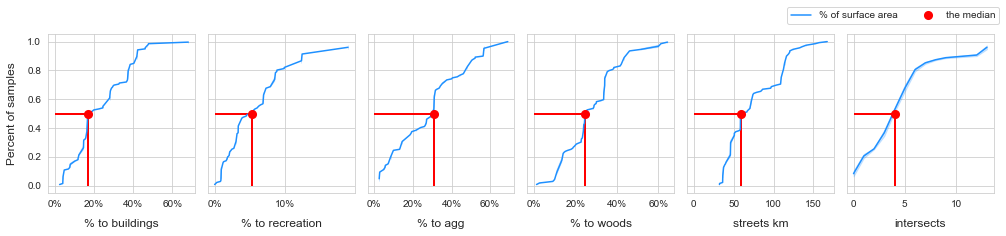

In [8]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

data = dfdt.copy()

for i, n in enumerate(luse_exp):
    ax=axs[i]
    # get the empirical distribution of the independent variable
    the_data = ECDF(data[n].values)
    x, y = the_data.x, the_data.y   
    
    # plot that
    sns.lineplot(x=x, y=y, ax=ax, color='dodgerblue', label="% of surface area")
    
    # get the median from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=2)
    
    # save the handels and labels but remove them from the ax    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    
    # format the % of total on the xaxis:
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("Percent of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, '%'))        
    else:
        pass
    ax.set_xlabel(n, **ck.xlab_k)

plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(1,1.1), loc='upper right', ncol=2)
plt.show()

#### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

In [9]:
site_string = F"""The survey locations represent the land use conditions accesible to approximateley {pop_string} people and a
variety of land use conditions within the survey area. For more information see the document *Survey site selection and criteria*.
"""
md(site_string)

The survey locations represent the land use conditions accesible to approximateley 493,799 people and a
variety of land use conditions within the survey area. For more information see the document *Survey site selection and criteria*.


[Menu](#toc)<a id="aggregatedtotals"></a>
### Cumulative totals by water feature

In [10]:
# aggregate the dimensional data down to the lake or river
dims_table = som_dims.groupby(['water_name_slug']).agg({'quantity':'sum','total_w':'sum', 'mac_plast_w':'sum', 'area':'sum', 'length':'sum'})

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, 'samples'] = fd_dt[fd_dt.water_name_slug == name].loc_date.nunique()

# add proper names for display
dims_table['water_feature'] = dims_table.index.map(lambda x: wname_wname.loc[x][0])
dims_table.set_index('water_feature', inplace=True)
   
# get the sum of all survey areas
dims_table.loc['Aare survey area']= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={'samples':'samples','quantity':'items', 'total_w':'total kg', 'mac_plast_w':'plastic kg', 'area':'m²', 'length':'meters'}, inplace=True)

# order the columns
dims_table = dims_table[['samples', *dims_table.columns[:-1]]]

# format kilos
dims_table['plastic kg'] = dims_table['plastic kg']/1000

In [11]:
# figure caption
agg_caption = F"""
*{level_names[0]} table of results: water features*

*m² and meters is the cumulative sum of all the surveys in the survey area or water feature*
"""
md(agg_caption)


*Aare survey area table of results: water features*

*m² and meters is the cumulative sum of all the surveys in the survey area or water feature*


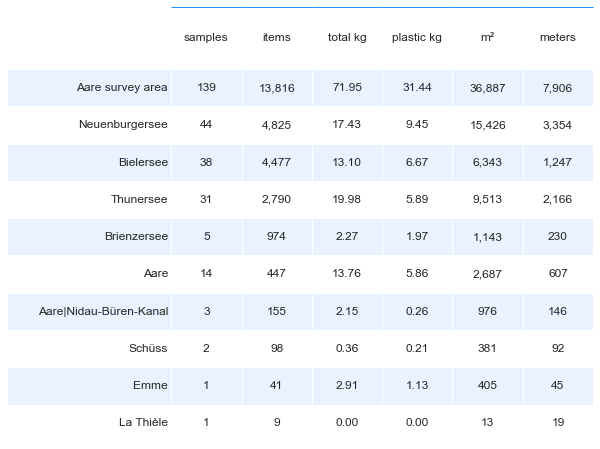

In [12]:
a_color='dodgerblue'

dims_table[[x for x in dims_table.columns if x not in ['plastic kg', 'total kg']]] = dims_table[[x for x in dims_table.columns if x not in ['plastic kg', 'total kg']]].applymap(lambda x: '{:,}'.format(int(x)))
dims_table[['plastic kg', 'total kg']] = dims_table[['plastic kg', 'total kg']].applymap(lambda x: '{:.2f}'.format(x))


data = dims_table.reset_index()

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.28, *[.12]*6], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Survey totals pieces per meter

In [13]:
# assign a month column to the survey totals
fd_dt['month'] = fd_dt.date.dt.month

# make a df of survey totals with date as index
# only the surveys from all other survey areas
dts_date = a_dt[~a_dt.water_name_slug.isin(fd.water_name_slug.unique())].set_index('date')

# the surveys from the river bassin
fd_dindex = fd_dt.set_index('date')

# samples were taken quarterly in ticino
if bassin_name == 'ticino':
    monthly_plot = fd_dindex[unit_label].resample('Q').median()
else:
    monthly_plot = fd_dindex[unit_label].resample('M').median()

[Annex](#annex)<a id="inventory" ></a>
#### Inventory of all items